# Practice Session 08: Data streams

In this session we will take a large corpus of documents and compute some statistics using data streams methods.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

Author: <font color="blue">Luca Franceschi</font>

E-mail: <font color="blue">luca.franceschi01@estudiant.upf.edu</font>

Date: <font color="blue">4/12/2024</font>

In [118]:
import io
import nltk
import gzip
import random
import statistics
import secrets
import re
import gzip
import time
import matplotlib.pyplot as plt
import numpy as np
import json

In [20]:
# nltk.download('punkt_tab')
# nltk.download('averaged_perceptron_tagger_eng')

# 0. Dataset and how to iterate

The input file contain lines of dialogue of a set of movies from the [Movie Dialog Corpus](https://www.kaggle.com/datasets/Cornell-University/movie-dialog-corpus). We will use the file `movie_lines.tsv` which contains the text of the dialogue, about 3 million words in about 300,000 lines of dialogue.

During this practice, **we will never load this file in memory.**

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [21]:
# Leave this code as-is

INPUT_FILE = 'movie_lines.tsv.gz'

The function `read_by_words` is a [generator](https://wiki.python.org/moin/Generators), that is, a function that behaves as an iterator. This is a common pattern used in stream processing, and in Python is implemented with the `yield` keyword, instead of `return`.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [22]:
# Leave this code as-is

POS_NOUN = 'NN'
POS_VERB = 'VB'
POS_ADJECTIVE = 'JJ'


# Producer in Python that reads a file by words that are nouns
def read_by_parts_of_speech(filename, parts_of_speech, max_words=-1, report_every=-1):

    # Open the input file
    with gzip.open(filename, 'rt', encoding='utf8') as file:

        # Initialize counter of words to stop at max_words
        counter = 0

        # Iterate through lines in the file
        for line in file:

            elements = line.split('\t')

            text = ""
            if len(elements) >= 5:
                text = elements[4].strip()

            if counter > max_words and max_words != -1:
                break

            for sentence in nltk.sent_tokenize(text):

                tagged = nltk.pos_tag(nltk.word_tokenize(sentence))
                for word in [part[0] for part in tagged if part[1] in parts_of_speech]:

                    counter += 1

                    # Report
                    if (report_every != -1) and (counter % report_every == 0):
                        if max_words == -1:
                            print('- Read %d words so far' % (counter))
                        else:
                            print('- Read %d/%d words so far' % (counter, max_words))

                    # Produce the word in lowercase
                    yield word.lower()

We will do a first pass over the data. Here we will read only the first 30K nouns. Try with a larger limit if your computer is fast, with a lower limit if your computer is slow. Find something that makes one pass take about 30 seconds and use it for development.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [23]:
for word in read_by_parts_of_speech(
    INPUT_FILE, [POS_ADJECTIVE], max_words=30000, report_every=10000
):
    # Prints 1/1000 of words
    if random.random() < 0.001:
        print('Current noun \'%s\'' % (word))

Current noun 'able'
Current noun 'weak'
Current noun 'west'
Current noun 'blind'
Current noun 'big'
Current noun 'dead'
Current noun 'epileptic'
Current noun 'other'
Current noun 'long'
- Read 10000/30000 words so far
Current noun 'able'
Current noun 'long'
Current noun 'sensory'
Current noun 'familiar'
Current noun 'okay'
Current noun 'able'
Current noun 'amazing'
- Read 20000/30000 words so far
Current noun 'bad'
Current noun 'professional'
Current noun 'sad'
Current noun 'great'
Current noun 'pretty'
Current noun 'late'
Current noun 'sorry'
Current noun 'drunk'
Current noun 'ten'
Current noun 'fifteen'
Current noun 'happy'
- Read 30000/30000 words so far


**Tip:** NLTK may complain that you have some missing files. The following commands may help:

```python3
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger_eng')
```

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

# 1. Determine approximately the top-10 words

Instead of loading the entire dataset in main memory, we will use reservoir sampling to determine approximately the top-10 words.

**Reservoir sampling**: In reservoir sampling, if we have a reservoir of size S:

* We store the first S elements of the stream
* When the n<sup>th</sup> element arrives (let's call it X<sub>n</sub>):
   * With probability 1 - s/n, we ignore this element.
   * With probability s/n, we:
      * Discard a random element from the reservoir
      * Add element X<sub>n</sub> to the reservoir (calling *add_to_reservoir*)
      
<font size="-1" color="gray">(Remove this cell when delivering.)</font>

Implement a function `add_reservoir(reservoir, item, max_size)` that adds an item to the reservoir, maintaining its size. If the reservoir is already of size *max_size*, a random item is selected and evicted *before* adding the item. It is important to evict an old item *before* adding the new item. Use the following skeleton:

```python
def add_to_reservoir(reservoir, item, max_reservoir_size):
    # YOUR CODE HERE
    assert(len(reservoir) <= max_reservoir_size)
```

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your code for "add_reservoir"</font>

In [24]:
def add_to_reservoir(reservoir: list, item, max_reservoir_size):
    if len(reservoir) == max_reservoir_size:
        if random.random() < 1 / max_reservoir_size:
            reservoir[random.choice(range(max_reservoir_size))] = item
    else:
        reservoir.append(item)
    assert len(reservoir) <= max_reservoir_size

Create a function to iterate through the file using the reservoir sampling method seen in class. In this function you will decide, for every item, whether to call *add_to_reservoir* or to ignore the item.

You can use the following skeleton:

```python
def reservoir_sampling(filename, reservoir_size, max_words=-1, report_every=-1):
    reservoir = []
    
    words_read = 0
    
    for word in read_by_parts_of_speech(filename, max_words=max_words, report_every=report_every):
    
            # YOUR CODE HERE

    return (words_read, reservoir)
```

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your code for "reservoir_sampling"</font>

In [25]:
def reservoir_sampling(
    filename, parts_of_speech, reservoir_size, max_words=-1, report_every=-1
):
    reservoir = []

    words_read = 0

    for word in read_by_parts_of_speech(
        filename,
        max_words=max_words,
        report_every=report_every,
        parts_of_speech=parts_of_speech,
    ):

        add_to_reservoir(reservoir, word, reservoir_size)
        words_read += 1

    return (words_read, reservoir)

Test your function using the following code:

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [26]:
# Leave this code as-is

reservoir_size = 1500
(items_seen, reservoir) = reservoir_sampling(
    INPUT_FILE, [POS_ADJECTIVE], reservoir_size, max_words=30000, report_every=10000
)

print('Number of items seen    : %d' % items_seen)
print('Number of items sampled : %d' % len(reservoir))

- Read 10000/30000 words so far
- Read 20000/30000 words so far
- Read 30000/30000 words so far
Number of items seen    : 30001
Number of items sampled : 1500


The reservoir contains repeated items. You can compute the absolute frequencies of the top 20 using the following code.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [27]:
# Leave this code as-is

freq = {}
for item in reservoir:
    freq[item] = reservoir.count(item)

most_frequent_items = sorted(
    [(frequency, word) for word, frequency in freq.items()], reverse=True
)[:20]

for absolute_frequency, word in most_frequent_items:
    print('%d %s' % (absolute_frequency, word))

60 good
34 little
32 right
32 other
30 sure
24 last
23 real
23 bad
21 own
21 much
20 sorry
19 great
18 only
18 big
16 first
15 wrong
15 same
15 next
14 true
14 long


Write code to compute the 20 most frequent items in the reservoir and their relative frequencies, as percentages.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your code to print the top items and their relative frequencies</font>

In [28]:
for absolute_frequency, word in most_frequent_items:
    print(
        '{} {} ({:.2%})'.format(
            absolute_frequency, word, absolute_frequency / reservoir_size
        )
    )

60 good (4.00%)
34 little (2.27%)
32 right (2.13%)
32 other (2.13%)
30 sure (2.00%)
24 last (1.60%)
23 real (1.53%)
23 bad (1.53%)
21 own (1.40%)
21 much (1.40%)
20 sorry (1.33%)
19 great (1.27%)
18 only (1.20%)
18 big (1.20%)
16 first (1.07%)
15 wrong (1.00%)
15 same (1.00%)
15 next (1.00%)
14 true (0.93%)
14 long (0.93%)


If you see an item C times in the reservoir, you can estimate the item appears *C x dataset_size / reservoir_size* times in the entire dataset (*dataset_size* is the size of the entire dataset). 

For various sizes of the reservoir, e.g., 50, 100, 500, ..., list the top-5 words and your estimate of their frequency in the entire dataset.
 
<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Increase the max limit of words so that one pass takes about 2-3 minutes to be completed. Replace this cell with your code to try different reservoir sizes. In each case, print your estimate for the relative and absolute frequency of the words in the entire dataset.</font>

In [29]:
sizes = [
    1000,
    1500,
    2999,
    3000,
    3001,
    6000,
    12000,
    15000,
    30000,
    50000,
    100000
]
top_n = 5
dataset_size = 3000000  # from the problem statement
max_words = 100000

for reservoir_size in sizes:
    print(f'Reservoir size = {reservoir_size} ({reservoir_size/dataset_size:.2%})')
    start = time.time()
    (_, reservoir) = reservoir_sampling(
        INPUT_FILE,
        [POS_ADJECTIVE],
        reservoir_size,
        max_words=max_words,
        report_every=10000,
    )

    freq = {}
    for item in reservoir:
        freq[item] = reservoir.count(item)
    most_frequent_items = sorted(
        [(frequency, word) for word, frequency in freq.items()], reverse=True
    )[:top_n]

    print(
        '{:<19s} \u2502 {:<8s} \u2502 {:<8s} \u2502 {:<19s}'.format(
            'word', 'abs_freq', 'rel_freq', 'E(abs_freq|dataset)'
        )
    )
    print(
        '{:\u2500<20s}\u253C{:\u2500<10s}\u253C{:\u2500<10s}\u253C{:\u2500<21s}'.format(
            '', '', '', ''
        )
    )
    for absolute_frequency, word in most_frequent_items:
        print(
            '{:<19s} \u2502 {:^8d} \u2502 {:^8.2%} \u2502 {:^20d}'.format(
                word,
                absolute_frequency,
                absolute_frequency / reservoir_size,
                round(absolute_frequency * dataset_size / reservoir_size),
            )
        )

    end = time.time()
    print(
        f'========================= TIME: {end - start:.2f}s ========================='
    )

Reservoir size = 1000 (0.03%)
- Read 10000/100000 words so far
- Read 20000/100000 words so far
- Read 30000/100000 words so far
- Read 40000/100000 words so far
- Read 50000/100000 words so far
- Read 60000/100000 words so far
- Read 70000/100000 words so far
- Read 80000/100000 words so far
- Read 90000/100000 words so far
- Read 100000/100000 words so far
word                │ abs_freq │ rel_freq │ E(abs_freq|dataset)
────────────────────┼──────────┼──────────┼─────────────────────
good                │    35    │  3.50%   │        105000       
sure                │    21    │  2.10%   │        63000        
other               │    20    │  2.00%   │        60000        
right               │    18    │  1.80%   │        54000        
little              │    18    │  1.80%   │        54000        
========================= TIME: 73.95s =========================
Reservoir size = 1500 (0.05%)
- Read 10000/100000 words so far
- Read 20000/100000 words so far
- Read 30000/100000 word

Find by trial and error, and include in your report, the minimum reservoir size you need to have somewhat stable results (e.g., the same top-3 words in two consecutive runs of the algorithm).

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with a brief commentary indicating what reservoir size you would recommend to use, and your overall conclusions.</font>

The optimal reservoir size may depend on the max_words value and the specific dataset, in this case with about 0.10% of the total dataset size read, the results tend to stabilize. However for even more stable results bigger reservoir sizes may be used. This choice typically depends on the system specifications of the device running this code and how many samples it can handle. Personally I wouldn't run this with more than reservoir size 50000 and max_words also 50000.

# 2. Determine approximately the distinct number of words

We will estimate the number of distinct words without creating a dictionary or hash table, but instead, we will use the Flajolet-Martin probabilistic counting method.

**Flajolet-Martin probabilistic counting**:

* For several passes
   * Create hash funcion h
   * For every element *u* in the stream:
      * Compute hash value *h(u)*
      * Let *r(u)* be the number of trailing zeroes in *h(u)*
      * Maintain *R* as the maximum value of *r(u)* seen so far
   * Add *2<sup>R</sup>* as an estimate for the number of distinct elements *u* seen
* The final estimate is the average or the median of the estimates found in each pass

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

Use this function to count trailing zeroes in the binary representation of a number.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [30]:
# Leave this code as-is


def count_trailing_zeroes(number):
    count = 0
    while number & 1 == 0:
        count += 1
        number = number >> 1
    return count

Use this function to generate a random hash function. Note this generates a function, so you can do `hash_function = random_hash_function()` and then call `hash_function(x)` to compute the hash value of `x`. 

We want to make sure each hash is different, so we will create each hash function with a different [salt](https://en.wikipedia.org/wiki/Salt_(cryptography)), which is an additional input that we will take using a good random string generator from the [secrets](https://docs.python.org/3/library/secrets.html) library.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [31]:
# Leave this code as-is


def random_hash_function():
    # We use a cryptographically safe generator for the salt of our hash function
    salt = secrets.token_bytes(32)
    return lambda string: hash(string + str(salt))

Perform *number_of_passes* passes over the file, reading the entire file on each pass (we don't use the reservoir in this part). In each pass, create a new hash function and use it to hash userids. Keep the maximum number of trailing zeroes seen in the hash value of a userid. 

```python
number_of_passes = 5
estimates = []

for i in range(number_of_passes):
    # YOUR_CODE_HERE: read the file and generate an estimate
    
    estimates.append(estimate)
    print("Estimate on pass %d: %d distinct words" % (i+1, estimate))
```

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your code to perform the requested number of passes.</font>

In [32]:
number_of_passes = 5


def probabilistic_counting(
    number_of_passes, filename, parts_of_speech, max_words=30000, report_every=10000, verbose=True
):
    estimates = []

    for i in range(number_of_passes):
        # YOUR_CODE_HERE: read the file and generate an estimate
        hash_function = random_hash_function()
        estimate = -1
        for word in read_by_parts_of_speech(
            filename, parts_of_speech, max_words, report_every
        ):
            estimate = max(estimate, count_trailing_zeroes(hash_function(word)))
        estimate = 2**estimate
        estimates.append(estimate)
        if verbose:
            print('Estimate on pass %d: %d distinct words' % (i + 1, estimate))
    return estimates


estimates = probabilistic_counting(number_of_passes, INPUT_FILE, [POS_ADJECTIVE])

- Read 10000/30000 words so far
- Read 20000/30000 words so far
- Read 30000/30000 words so far
Estimate on pass 1: 4096 distinct words
- Read 10000/30000 words so far
- Read 20000/30000 words so far
- Read 30000/30000 words so far
Estimate on pass 2: 4096 distinct words
- Read 10000/30000 words so far
- Read 20000/30000 words so far
- Read 30000/30000 words so far
Estimate on pass 3: 16384 distinct words
- Read 10000/30000 words so far
- Read 20000/30000 words so far
- Read 30000/30000 words so far
Estimate on pass 4: 16384 distinct words
- Read 10000/30000 words so far
- Read 20000/30000 words so far
- Read 30000/30000 words so far
Estimate on pass 5: 1024 distinct words


In [33]:
# Leave this code as-is

print('* Average of estimates: %.1f' % statistics.mean(estimates))
print('* Median  of estimates: %.1f' % statistics.median(estimates))

* Average of estimates: 8396.8
* Median  of estimates: 4096.0


You can increase the limit of words to read (but do not use more than 5 minutes of computing time), and perform the 10 passes. 

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Compute the median of average estimates in 3 separate runs of your algorithm; each run should do 10 passes over the file. Repeat this for nouns (POS_NOUN), adjectives (POS_ADJECTIVE), and verbs (POS_VERB). Replace this cell with the results you obtained in each pass, and whether the average or the median seem more appropriate for this probabilistic counting.</font>

In [34]:
parts_of_speech = [(POS_NOUN), (POS_ADJECTIVE), (POS_VERB)]
number_of_passes = 10

estimates = {}

for part_of_speech in parts_of_speech:
    print(f'Counting {part_of_speech} part of speech')
    start = time.time()
    estimates[part_of_speech] = probabilistic_counting(
        number_of_passes, INPUT_FILE, part_of_speech, report_every=-1
    )
    end = time.time()
    print(f'============ TIME: {end - start:.2f}s ============')

Counting NN part of speech
Estimate on pass 1: 8192 distinct words
Estimate on pass 2: 4096 distinct words
Estimate on pass 3: 8192 distinct words
Estimate on pass 4: 4096 distinct words
Estimate on pass 5: 1024 distinct words
Estimate on pass 6: 2048 distinct words
Estimate on pass 7: 2048 distinct words
Estimate on pass 8: 4096 distinct words
Estimate on pass 9: 32768 distinct words
Estimate on pass 10: 4096 distinct words
============ TIME: 108.17s ============
Counting JJ part of speech
Estimate on pass 1: 32768 distinct words
Estimate on pass 2: 4096 distinct words
Estimate on pass 3: 8192 distinct words
Estimate on pass 4: 2048 distinct words
Estimate on pass 5: 2048 distinct words
Estimate on pass 6: 8192 distinct words
Estimate on pass 7: 8192 distinct words
Estimate on pass 8: 8192 distinct words
Estimate on pass 9: 4096 distinct words
Estimate on pass 10: 1024 distinct words
============ TIME: 261.07s ============
Counting VB part of speech
Estimate on pass 1: 2048 distinct w

In [35]:
for key in estimates:
    print(f'Statistics for {key} part of speech')
    print('* Average of estimates: %.1f' % statistics.mean(estimates[key]))
    print('* Median  of estimates: %.1f' % statistics.median(estimates[key]))

Statistics for NN part of speech
* Average of estimates: 7065.6
* Median  of estimates: 4096.0
Statistics for JJ part of speech
* Average of estimates: 7884.8
* Median  of estimates: 6144.0
Statistics for VB part of speech
* Average of estimates: 5888.0
* Median  of estimates: 2048.0


I would say that the median is more appropiate since there is some small chance that we get a hash function that maps a single word to a number that has a ton of trailing zeros, causing the estimate of a single pass to be a couple of orders of magnitude higher, driving the average to a much higher value than expected. This happens in our run with the NN (nouns) part of speech. We can say that the median is more stable in this probabilistic counting situation.

# Extra: Heap's Law

For more learning and extra points, notice that the number of **distinct** words in a corpus, as a function of the **total** number of words in the corpus, follows an empirical law known as [Heap's Law](https://en.wikipedia.org/wiki/Heaps%27_law).

Repeat the probabilistic counting experiment for various values of `max_word` and plot the total number of words read versus the number of distinct words (remember to label axes). Check if it follows Heap's law for nouns, verbs, and adjectives.

Please note that using probabilistic counting means a substantial amount of noise will be introduced and perhaps the Heap's law will not be clear in your plot.

**Note:** if you go for the extra points, add ``<font size="+2" color="blue">Additional results: Heap's law</font>`` at the top of your notebook. 

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [131]:
def f(x):
    return np.exp(-x)*2e5

In [133]:
parts_of_speech = [(POS_NOUN), (POS_ADJECTIVE), (POS_VERB)]
# max_word_iter = np.round(np.linspace(0, 200000, 10)) # 10 datapoints in the plot seems enough
max_word_iter = np.sort(np.round(f(np.linspace(0, 3, 30)))) # non linearly distributed array which contains more datapoints in the beginning (where plot is more steep we need more quality)
number_of_passes = 10

estimates = {}

for part_of_speech in parts_of_speech:
    print(f'Counting {part_of_speech} part of speech')
    start = time.time()
    estimates[part_of_speech] = []
    for max_words in max_word_iter:
        start2 = time.time()
        print(f'On iteration: max_words={max_words}')
        estimates[part_of_speech].append(probabilistic_counting(
            number_of_passes, INPUT_FILE, part_of_speech, report_every=-1, max_words=max_words, verbose=False
        ))
        end2 = time.time()
        print(f'-------- TIME: {end2 - start2:.2f}s --------')
    end = time.time()
    print(f'============ TIME: {end - start:.2f}s ============')

Counting NN part of speech
On iteration: max_words=9957.0
-------- TIME: 31.19s --------
On iteration: max_words=11043.0
-------- TIME: 36.85s --------
On iteration: max_words=12246.0
-------- TIME: 39.22s --------
On iteration: max_words=13581.0
-------- TIME: 43.04s --------
On iteration: max_words=15061.0
-------- TIME: 48.90s --------
On iteration: max_words=16703.0
-------- TIME: 53.58s --------
On iteration: max_words=18523.0


KeyboardInterrupt: 

In [ ]:
with open('estimates.json', 'w') as fp:
    json.dump(estimates, fp)

# with open('estimates.json', 'r') as fp:
#     estimates = json.load(fp)

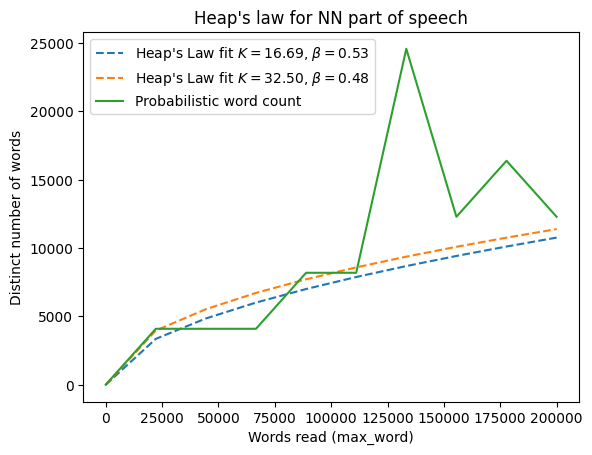

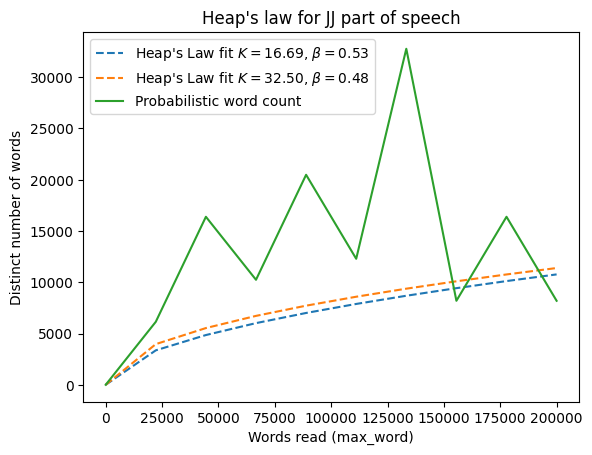

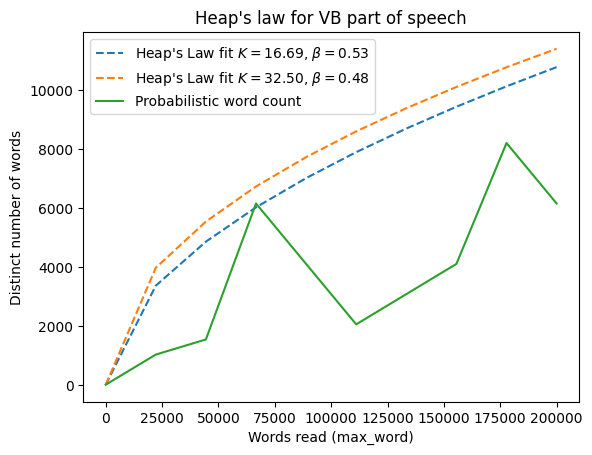

In [130]:
def plot_heaps_law(estimates, max_word_iter, part_of_speech, betas, kappas):
    plt.figure()
    for b, k in zip(betas, kappas):
        heaps_fit = k * max_word_iter**b
        plt.plot(max_word_iter, heaps_fit, linestyle='dashed', label=f'Heap\'s Law fit $K={k:.2f}$, $\\beta={b:.2f}$')
        
    plt.plot(max_word_iter, [statistics.median(estimates[part_of_speech][i]) for i in range(len(estimates[part_of_speech]))], label='Probabilistic word count')
    plt.xlabel('Words read (max_word)')
    plt.ylabel('Distinct number of words')
    plt.title(f'Heap\'s law for {part_of_speech} part of speech')
    plt.legend()
    plt.show()


betas = [0.53, 0.48]
kappas = [16.69, 32.5]
for part_of_speech in parts_of_speech:
    plot_heaps_law(estimates, max_word_iter, part_of_speech, betas, kappas)

# DELIVER (individually)

Remember to read the section on "delivering your code" in the [course evaluation guidelines](https://github.com/chatox/data-mining-course/blob/master/upf/upf-evaluation.md).

Deliver a zip file containing:

* This notebook

<font size="+2" color="#003300">I hereby declare that, except for the code provided by the course instructors, all of my code, report, and figures were produced by myself.</font>